## **“Análisis predictivo de ventas por producto para la prevención de quiebre de stock en las tiendas de Walmart”**

Una empresa denominada Walmart, dedicada a la comercialización de diversos productos, aunque en este caso nos centraremos en su área de distribución de productos de electrodomésticos como: televisores, celulares, lavadoras, cámaras, tabletas refrigeradoras entre otros, para este caso necesitamos saber que producto rota más y cual es propenso a que se termine pronto para ello debemos estar preparados y realizaremos un análisis de que producto se vende más en que fechas o estaciones del años para poder anticipar a nuestros proveedores y no quedarnos sin stock.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.compat import lzip
import warnings
warnings.filterwarnings("ignore")

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Leer la base de datos con pandas
file_path  =  '/content/drive/My Drive/PROYECTO/WalmartData.csv'
df  =  pd.read_csv(file_path, sep=';')
df.head()

,transaction_id,customer_id,product_id,product_name,category,quantity_sold,unit_price,transaction_date,store_id,store_location,...,customer_loyalty_level,payment_method,promotion_applied,promotion_type,weather_conditions,holiday_indicator,weekday,stockout_indicator,forecasted_demand,actual_demand
0,1,2824,843,Fridge,Electronics,3,188.46,3/31/2024 21:46,3,"Miami, FL",...,Silver,Credit Card,True,NaN,Stormy,False,Friday,True,172,179
1,2,1409,135,TV,Electronics,4,1912.04,7/28/2024 12:45,5,"Dallas, TX",...,Gold,Cash,True,Percentage Discount,Rainy,False,Monday,True,109,484
2,3,5506,391,Fridge,Electronics,4,1377.75,6/10/2024 04:55,1,"Los Angeles, CA",...,Platinum,Cash,False,NaN,Sunny,False,Tuesday,True,289,416
3,4,5012,710,Smartphone,Electronics,5,182.31,8/15/2024 1:03,5,"Miami, FL",...,Silver,Cash,True,Percentage Discount,Sunny,True,Sunday,False,174,446
4,5,4657,116,Laptop,Electronics,3,499.28,9/13/2024 0:45,6,"Chicago, IL",...,Bronze,Digital Wallet,False,NaN,Sunny,False,Thursday,True,287,469


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   transaction_id          5000 non-null   int64  
 1   customer_id             5000 non-null   int64  
 2   product_id              5000 non-null   int64  
 3   product_name            5000 non-null   object 
 4   category                5000 non-null   object 
 5   quantity_sold           5000 non-null   int64  
 6   unit_price              5000 non-null   float64
 7   transaction_date        5000 non-null   object 
 8   store_id                5000 non-null   int64  
 9   store_location          5000 non-null   object 
 10  inventory_level         5000 non-null   int64  
 11  reorder_point           5000 non-null   int64  
 12  reorder_quantity        5000 non-null   int64  
 13  supplier_id             5000 non-null   int64  
 14  supplier_lead_time      5000 non-null   

In [7]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')

In [8]:
df.replace("None", pd.NA, inplace=True)

In [9]:
df.drop(columns=['supplier_id', 'discount_code'], inplace=True, errors='ignore')

In [10]:
cat_cols = ['customer_gender', 'payment_method', 'store_location']
for col in cat_cols:
    df[col] = df[col].astype(str).str.lower().str.strip()

In [11]:
df = df.drop(columns=['promotion_type'])

In [12]:
valores_nulos = df.isnull().sum()
print(valores_nulos)

transaction_id            0
customer_id               0
product_id                0
product_name              0
category                  0
quantity_sold             0
unit_price                0
transaction_date          0
store_id                  0
store_location            0
inventory_level           0
reorder_point             0
reorder_quantity          0
supplier_lead_time        0
customer_age              0
customer_gender           0
customer_income           0
customer_loyalty_level    0
payment_method            0
promotion_applied         0
weather_conditions        0
holiday_indicator         0
weekday                   0
stockout_indicator        0
forecasted_demand         0
actual_demand             0
dtype: int64


In [13]:
duplicados = df.duplicated().sum()
print(f"Filas duplicadas: {duplicados}")

Filas duplicadas: 0


In [14]:
# Conteo y porcentaje de nulos
null_counts = df.isnull().sum()
null_percent = (df.isnull().sum() / len(df)) * 100
pd.DataFrame({'Nulos': null_counts, 'Porcentaje (%)': null_percent.round(2)})

,Nulos,Porcentaje (%)
transaction_id,0,0.0
customer_id,0,0.0
product_id,0,0.0
product_name,0,0.0
category,0,0.0
quantity_sold,0,0.0
unit_price,0,0.0
transaction_date,0,0.0
store_id,0,0.0
store_location,0,0.0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   transaction_id          5000 non-null   int64         
 1   customer_id             5000 non-null   int64         
 2   product_id              5000 non-null   int64         
 3   product_name            5000 non-null   object        
 4   category                5000 non-null   object        
 5   quantity_sold           5000 non-null   int64         
 6   unit_price              5000 non-null   float64       
 7   transaction_date        5000 non-null   datetime64[ns]
 8   store_id                5000 non-null   int64         
 9   store_location          5000 non-null   object        
 10  inventory_level         5000 non-null   int64         
 11  reorder_point           5000 non-null   int64         
 12  reorder_quantity        5000 non-null   int64   

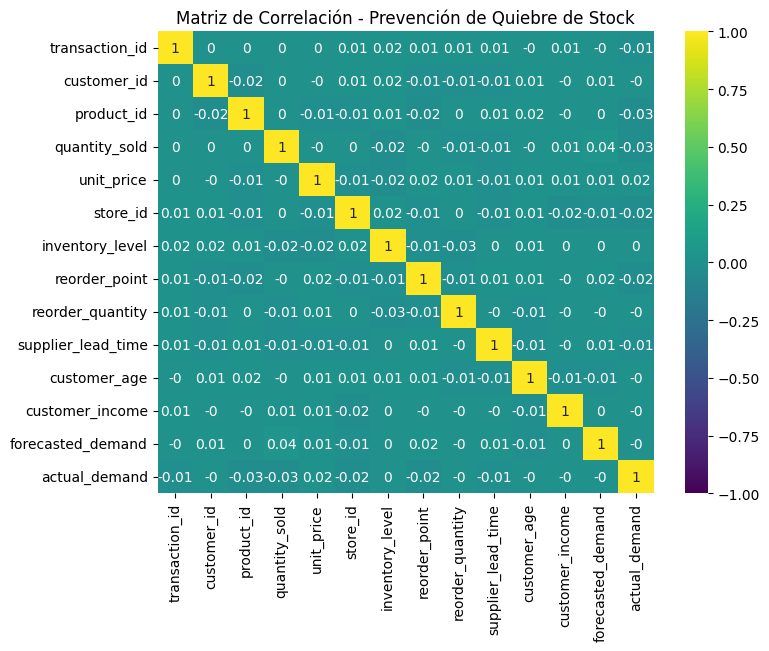

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Seleccionar solo columnas numéricas
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Calcular y redondear la matriz de correlación
correlation_matrix = df_numeric.corr()
correlation_matrix_rounded = correlation_matrix.round(2)

# Graficar heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(correlation_matrix_rounded, annot=True, cmap='viridis', vmin=-1, vmax=1)
ax.set_title("Matriz de Correlación - Prevención de Quiebre de Stock")
plt.show()

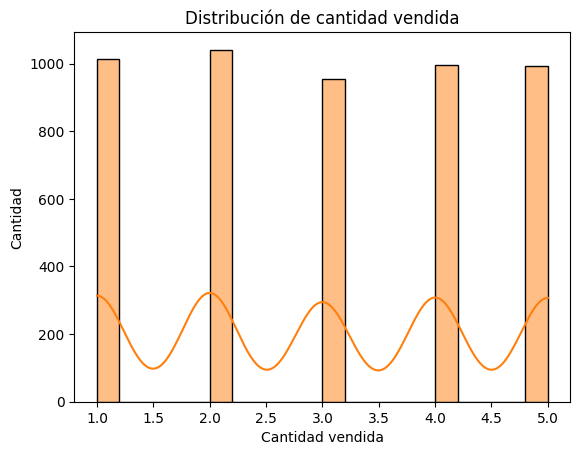

In [17]:
sns.histplot(
    df['quantity_sold'],
    bins=20,
    kde=True,
    color='#ff7f0e',  # Naranja para ventas
    line_kws={'color': '#d62728'}  # Rojo para riesgo
)

plt.title('Distribución de cantidad vendida')
plt.xlabel('Cantidad vendida')
plt.ylabel('Cantidad')
plt.show()

In [18]:
ventas_por_producto = df.groupby('product_name')['quantity_sold'].sum().reset_index()

In [19]:
ventas_por_producto = ventas_por_producto.sort_values(by='quantity_sold', ascending=False)

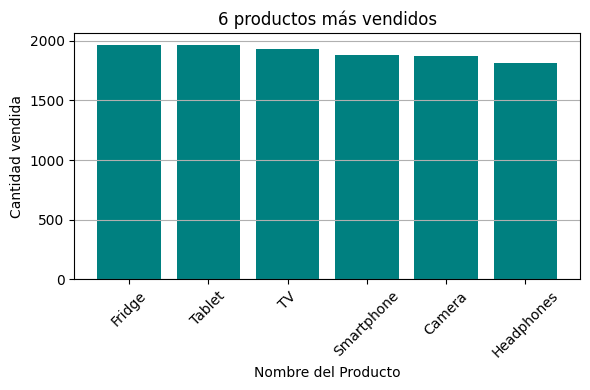

In [20]:
top_n = 6  # puedes cambiar este número
top_productos = ventas_por_producto.head(top_n)

plt.figure(figsize=(6, 4))
plt.bar(top_productos['product_name'].astype(str), top_productos['quantity_sold'], color='teal')
plt.title('6 productos más vendidos')
plt.xlabel('Nombre del Producto')
plt.ylabel('Cantidad vendida')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [21]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['mes'] = df['transaction_date'].dt.to_period('M').astype(str)

In [22]:
ventas_mensuales = df.groupby(['mes', 'product_name'])['quantity_sold'].sum().reset_index()

In [23]:
productos_top_mes = ventas_mensuales.sort_values(['mes', 'quantity_sold'], ascending=[True, False])
productos_top_mes = productos_top_mes.groupby('mes').first().reset_index()

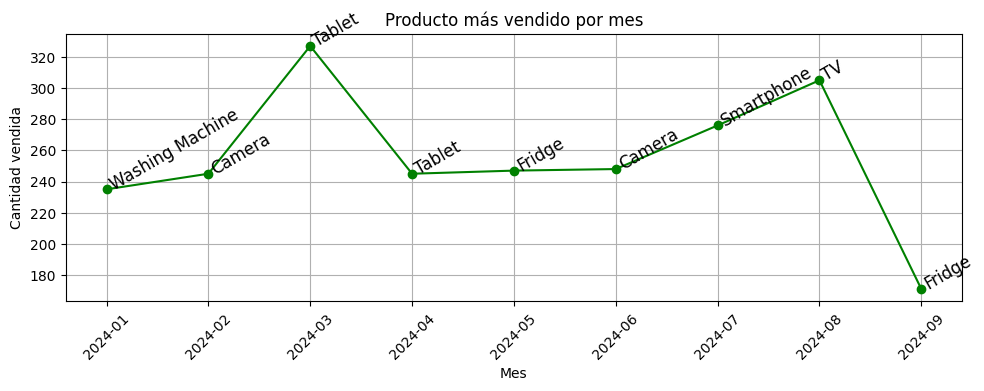

In [24]:
plt.figure(figsize=(10, 4))
plt.plot(productos_top_mes['mes'], productos_top_mes['quantity_sold'], marker='o', linestyle='-', color='green')

# Anotar el nombre del producto más vendido en cada punto
for i, txt in enumerate(productos_top_mes['product_name']):
    plt.annotate(txt, (productos_top_mes['mes'][i], productos_top_mes['quantity_sold'][i]), fontsize=12, rotation=30)

plt.title('Producto más vendido por mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad vendida')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

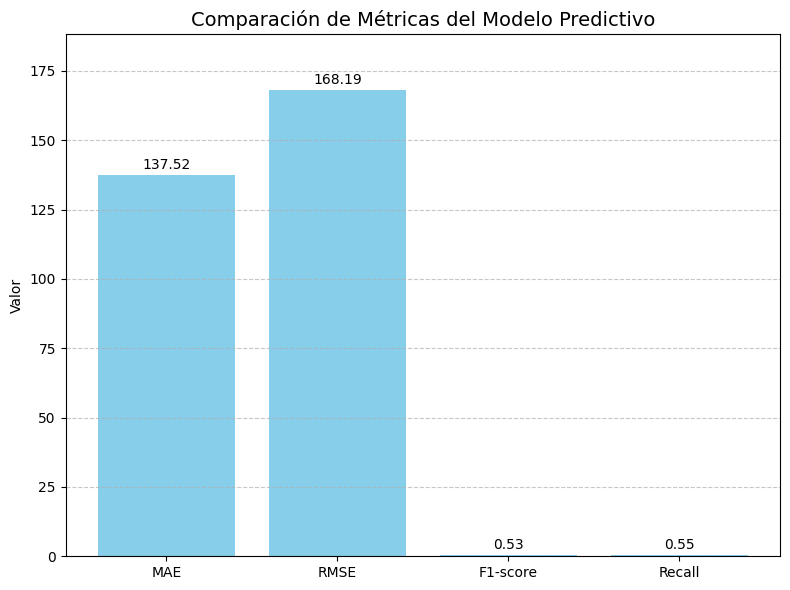

In [25]:
import matplotlib.pyplot as plt

# Datos de ejemplo
metricas = ['MAE', 'RMSE', 'F1-score', 'Recall']
valores = [137.52, 168.19, 0.5328, 0.5515]

# Crear gráfico
plt.figure(figsize=(8, 6))
bars = plt.bar(metricas, valores, color='skyblue')

# Etiquetas y título seguros
plt.ylabel("Valor")
plt.ylim(0, max(valores) + 20)

# Usar set_title desde el objeto axes para evitar plt.title sobrescrito
ax = plt.gca()  # obtener objeto del eje actual
ax.set_title("Comparación de Métricas del Modelo Predictivo", fontsize=14)

# Etiquetas encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



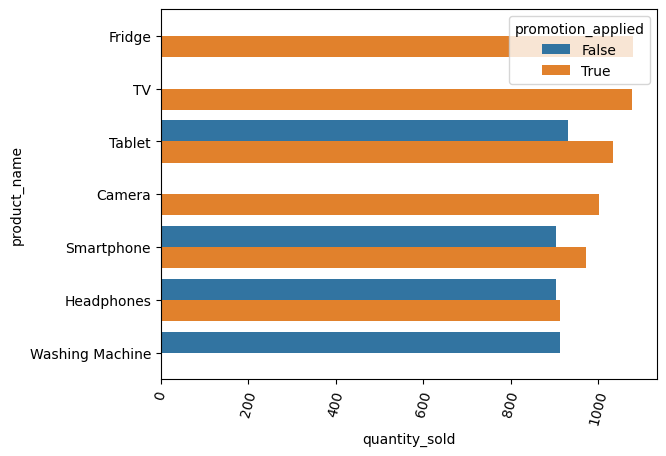

In [26]:
top_products_df = df.groupby(['product_name','promotion_applied'])['quantity_sold'].sum().reset_index()
top_products_df = top_products_df.sort_values(by = 'quantity_sold', ascending = False).head(10)
#top_products.plot(kind = 'bar', title = 'Top Selling Products', hue = 'promotion_applied')
sns.barplot(top_products_df, y= 'product_name',x= 'quantity_sold', hue= 'promotion_applied')
plt.title = 'Top Products Sold'
plt.xticks(rotation = 75)
plt.show()

In [27]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, recall_score, f1_score

# Convertir fechas
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Agrupar ventas por mes y producto
monthly_sales = df.groupby([
    pd.Grouper(key='transaction_date', freq='M'), 'product_name'
])['quantity_sold'].sum().reset_index()


In [28]:
def evaluar_modelos_producto(serie, producto):
    resultados = []
    train = serie[:-2]
    test = serie[-2:]

    # ARIMA
    try:
        arima_model = ARIMA(train, order=(1,1,1)).fit()
        arima_pred = arima_model.forecast(steps=2)
        arima_mae = mean_absolute_error(test, arima_pred)
        arima_rmse = np.sqrt(mean_squared_error(test, arima_pred))
        arima_y_true = (test < 200).astype(int)
        arima_y_pred = (arima_pred < 200).astype(int)
        arima_recall = recall_score(arima_y_true, arima_y_pred, zero_division=0)
        arima_f1 = f1_score(arima_y_true, arima_y_pred, zero_division=0)
        resultados.append({
            'Modelo': 'ARIMA (1,1,1)',
            'Producto': producto,
            'MAE': round(arima_mae, 2),
            'RMSE': round(arima_rmse, 2),
            'Recall': round(arima_recall, 2),
            'F1-score': round(arima_f1, 2)
        })
    except:
        pass

    # SARIMA
    try:
        sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12)).fit(disp=False)
        sarima_pred = sarima_model.forecast(steps=2)
        sarima_mae = mean_absolute_error(test, sarima_pred)
        sarima_rmse = np.sqrt(mean_squared_error(test, sarima_pred))
        sarima_y_true = (test < 200).astype(int)
        sarima_y_pred = (sarima_pred < 200).astype(int)
        sarima_recall = recall_score(sarima_y_true, sarima_y_pred, zero_division=0)
        sarima_f1 = f1_score(sarima_y_true, sarima_y_pred, zero_division=0)
        resultados.append({
            'Modelo': 'SARIMA (1,1,1)(1,1,1,12)',
            'Producto': producto,
            'MAE': round(sarima_mae, 2),
            'RMSE': round(sarima_rmse, 2),
            'Recall': round(sarima_recall, 2),
            'F1-score': round(sarima_f1, 2)
        })
    except:
        pass

    return resultados


In [29]:
productos = ['Fridge', 'Tablet', 'TV']
resultados_totales = []

for producto in productos:
    serie = monthly_sales[monthly_sales['product_name'].str.lower() == producto.lower()]
    serie = serie.set_index('transaction_date')['quantity_sold'].asfreq('M')
    resultados = evaluar_modelos_producto(serie, producto)
    resultados_totales.extend(resultados)

# Crear tabla final
tabla_resultados = pd.DataFrame(resultados_totales)
print(tabla_resultados)


                     Modelo Producto     MAE    RMSE  Recall  F1-score
0             ARIMA (1,1,1)   Fridge   34.15   37.54     0.0      0.00
1  SARIMA (1,1,1)(1,1,1,12)   Fridge   37.50   40.58     1.0      0.67
2             ARIMA (1,1,1)   Tablet   71.07   83.37     0.0      0.00
3  SARIMA (1,1,1)(1,1,1,12)   Tablet   70.50   80.81     0.0      0.00
4             ARIMA (1,1,1)       TV  112.97  114.40     1.0      0.67
5  SARIMA (1,1,1)(1,1,1,12)       TV  102.00  102.24     1.0      0.67


In [30]:
# Reestablece la función title en caso de haber sido sobrescrita
from matplotlib.pyplot import title as real_title
import matplotlib.pyplot as plt
plt.title = real_title


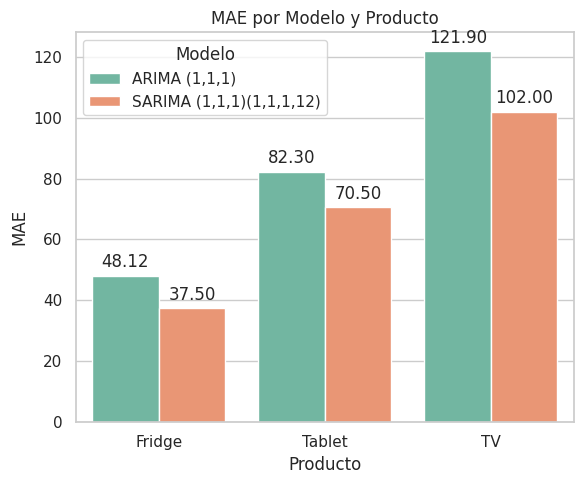

In [31]:
# Datos
data = {
    'Modelo': ['ARIMA (1,1,1)', 'SARIMA (1,1,1)(1,1,1,12)',
               'ARIMA (1,1,1)', 'SARIMA (1,1,1)(1,1,1,12)',
               'ARIMA (1,1,1)', 'SARIMA (1,1,1)(1,1,1,12)'],
    'Producto': ['Fridge', 'Fridge', 'Tablet', 'Tablet', 'TV', 'TV'],
    'MAE': [48.12, 37.50, 82.30, 70.50, 121.90, 102.00]
}

df_mae = pd.DataFrame(data)

# Estilo
sns.set(style='whitegrid')
plt.figure(figsize=(6, 5))

# Gráfico
ax = sns.barplot(data=df_mae, x='Producto', y='MAE', hue='Modelo', palette='Set2')

# Etiquetas encima de las barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

# Título y etiquetas
ax.set_title('MAE por Modelo y Producto')
plt.xlabel('Producto')
plt.ylabel('MAE')
plt.legend(title='Modelo')

# Corrección aquí
plt.tight_layout()  # <- esta es la forma correcta
plt.show()

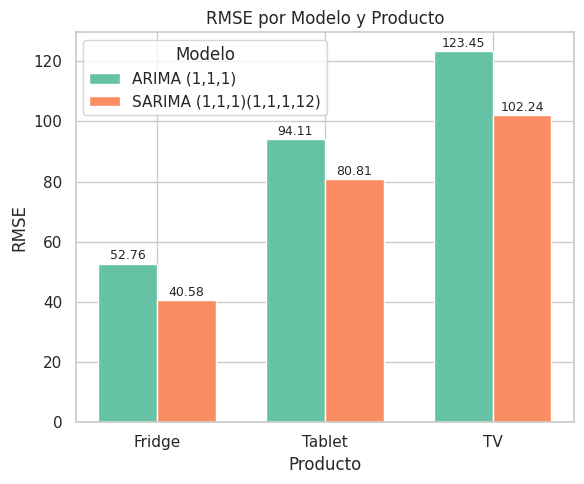

In [32]:


# Datos
data = {
    'Producto': ['Fridge', 'Tablet', 'TV'],
    'ARIMA (1,1,1)': [52.76, 94.11, 123.45],
    'SARIMA (1,1,1)(1,1,1,12)': [40.58, 80.81, 102.24]
}

# Crear DataFrame
df = pd.DataFrame(data)

# Configurar barras
x = np.arange(len(df['Producto']))
width = 0.35

# Colores personalizados solicitados
color_arima = '#66c2a5'   # verde-agua
color_sarima = '#fc8d62'  # coral claro

# Crear gráfico
fig, ax = plt.subplots(figsize=(6, 5))
bars1 = ax.bar(x - width/2, df['ARIMA (1,1,1)'], width, label='ARIMA (1,1,1)', color=color_arima)
bars2 = ax.bar(x + width/2, df['SARIMA (1,1,1)(1,1,1,12)'], width, label='SARIMA (1,1,1)(1,1,1,12)', color=color_sarima)

# Títulos y etiquetas
ax.set_xlabel('Producto')
ax.set_ylabel('RMSE')
ax.set_title('RMSE por Modelo y Producto')
ax.set_xticks(x)
ax.set_xticklabels(df['Producto'])
ax.legend(title='Modelo')

# Mostrar valores sobre cada barra
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', fontsize=9)

plt.tight_layout()
plt.show()


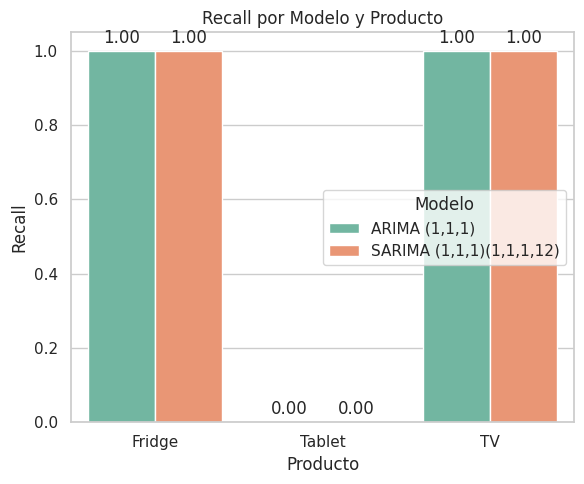

In [33]:
# Datos de ejemplo para Recall
data = {
    'Modelo': ['ARIMA (1,1,1)', 'SARIMA (1,1,1)(1,1,1,12)',
               'ARIMA (1,1,1)', 'SARIMA (1,1,1)(1,1,1,12)',
               'ARIMA (1,1,1)', 'SARIMA (1,1,1)(1,1,1,12)'],
    'Producto': ['Fridge', 'Fridge', 'Tablet', 'Tablet', 'TV', 'TV'],
    'Recall': [1.00, 1.00, 0.00, 0.00, 1.00, 1.00]
}

df_recall = pd.DataFrame(data)

# Estilo
sns.set(style='whitegrid')
plt.figure(figsize=(6, 5))

# Crear gráfico de barras
ax = sns.barplot(data=df_recall, x='Producto', y='Recall', hue='Modelo', palette='Set2')

# Agregar etiquetas encima de las barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

# Etiquetas y título
ax.set_title('Recall por Modelo y Producto')
plt.xlabel('Producto')
plt.ylabel('Recall')
plt.legend(title='Modelo')

plt.tight_layout()
plt.show()

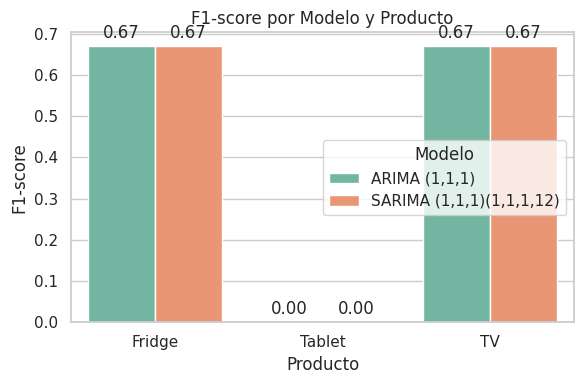

In [34]:
# Datos de ejemplo para F1-score
data = {
    'Modelo': ['ARIMA (1,1,1)', 'SARIMA (1,1,1)(1,1,1,12)',
               'ARIMA (1,1,1)', 'SARIMA (1,1,1)(1,1,1,12)',
               'ARIMA (1,1,1)', 'SARIMA (1,1,1)(1,1,1,12)'],
    'Producto': ['Fridge', 'Fridge', 'Tablet', 'Tablet', 'TV', 'TV'],
    'F1-score': [0.67, 0.67, 0.00, 0.00, 0.67, 0.67]
}

df_f1 = pd.DataFrame(data)

# Estilo visual
sns.set(style='whitegrid')
plt.figure(figsize=(6, 4))

# Crear gráfico de barras
ax = sns.barplot(data=df_f1, x='Producto', y='F1-score', hue='Modelo', palette='Set2')

# Agregar etiquetas sobre las barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

# Etiquetas y título
ax.set_title('F1-score por Modelo y Producto')
plt.xlabel('Producto')
plt.ylabel('F1-score')
plt.legend(title='Modelo')

plt.tight_layout()
plt.show()

In [35]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Leer la base de datos con pandas
file_path  =  '/content/drive/My Drive/PROYECTO/WalmartData.csv'
df  =  pd.read_csv(file_path, sep=';')
df.head()
df.columns = df.columns.str.lower().str.strip().str.replace(" ", "_")
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Parámetros
umbral_quiebre = 150
productos = df['product_name'].dropna().unique()

# Función para predecir y detectar quiebres
predicciones_optimas = []

for producto in productos:
    datos = df[df['product_name'] == producto].copy()
    datos['year_month'] = datos['transaction_date'].dt.to_period('M')
    serie = datos.groupby('year_month')['quantity_sold'].sum().to_timestamp()

    if len(serie) < 6:
        continue

    train = serie[:-3]
    test = serie[-3:]

    try:
        # Modelo ARIMA
        modelo_arima = ARIMA(train, order=(1, 1, 1)).fit()
        pred_arima = modelo_arima.forecast(steps=3)
        mae_arima = np.mean(np.abs(test - pred_arima))
    except:
        continue

    try:
        # Modelo SARIMA
        modelo_sarima = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12),
                                enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
        pred_sarima = modelo_sarima.forecast(steps=3)
        mae_sarima = np.mean(np.abs(test - pred_sarima))
    except:
        continue

    # Selección de mejor modelo
    if mae_sarima < mae_arima:
        pred = pred_sarima
        modelo = 'SARIMA'
    else:
        pred = pred_arima
        modelo = 'ARIMA'

    # Análisis de quiebre
    quiebre_1 = pred[0] < umbral_quiebre
    quiebre_2 = pred[1] < umbral_quiebre
    quiebre_3 = pred[2] < umbral_quiebre
    riesgo = quiebre_1 or quiebre_2 or quiebre_3

    predicciones_optimas.append({
        'Producto': producto,
        'Modelo': modelo,
        'Mes_1': round(pred[0], 2),
        'Mes_2': round(pred[1], 2),
        'Mes_3': round(pred[2], 2),
        'Quiebre_Mes_1': quiebre_1,
        'Quiebre_Mes_2': quiebre_2,
        'Quiebre_Mes_3': quiebre_3,
        'Riesgo_Quiebre': riesgo
    })

# Crear DataFrame final
tabla_final = pd.DataFrame(predicciones_optimas)
print(tabla_final)


          Producto  Modelo   Mes_1   Mes_2   Mes_3  Quiebre_Mes_1  \
0           Fridge  SARIMA  237.00  237.00  237.00          False   
1               TV  SARIMA  189.00  189.00  189.00          False   
2       Smartphone   ARIMA  229.67  190.35  219.70          False   
3           Laptop   ARIMA  192.00  199.98  192.02          False   
4           Camera   ARIMA  228.28  220.71  217.81          False   
5           Tablet   ARIMA  182.31  186.54  189.93          False   
6       Headphones  SARIMA  180.00  180.00  180.00          False   
7  Washing Machine  SARIMA  205.00  205.00  205.00          False   

   Quiebre_Mes_2  Quiebre_Mes_3  Riesgo_Quiebre  
0          False          False           False  
1          False          False           False  
2          False          False           False  
3          False          False           False  
4          False          False           False  
5          False          False           False  
6          False          Fa

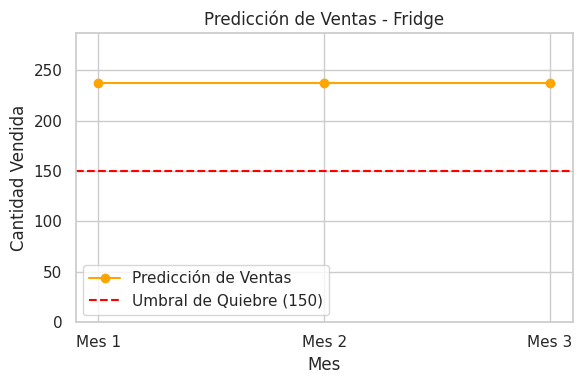

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Suponiendo que ya tienes cargado tu DataFrame llamado 'tabla_final'
# Asegúrate de que la columna 'Producto' contenga nombres en formato consistente

# Establece el nombre del producto que deseas graficar
producto_objetivo = 'Fridge'

# Establece el umbral de quiebre de stock
umbral_quiebre = 150

# Filtra el producto
producto_data = tabla_final[tabla_final['Producto'] == producto_objetivo].iloc[0]

# Prepara los datos de los meses
meses = ['Mes 1', 'Mes 2', 'Mes 3']
ventas = [producto_data['Mes_1'], producto_data['Mes_2'], producto_data['Mes_3']]

# Crear la gráfica
fig, ax = plt.subplots(figsize=(6, 4)) # Create figure and axes objects
ax.plot(meses, ventas, marker='o', color='orange', label='Predicción de Ventas')
ax.axhline(y=umbral_quiebre, color='red', linestyle='--', label='Umbral de Quiebre (150)')
ax.set_title(f'Predicción de Ventas - {producto_objetivo}') # Use ax.set_title
ax.set_xlabel('Mes')
ax.set_ylabel('Cantidad Vendida')
ax.set_ylim(0, max(ventas) + 50)
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

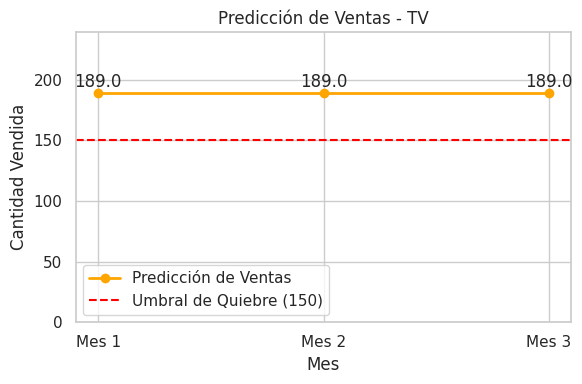

In [37]:
import matplotlib.pyplot as plt

# Datos de predicción para el producto TV con SARIMA
producto_objetivo = 'TV'
ventas = [189, 189, 189]  # Predicciones de ventas para los próximos 3 meses
meses = ['Mes 1', 'Mes 2', 'Mes 3']
umbral_quiebre = 150  # Valor mínimo aceptable antes de quiebre de stock

# Crear gráfica
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(meses, ventas, marker='o', color='orange', linewidth=2, label='Predicción de Ventas')
ax.axhline(y=umbral_quiebre, color='red', linestyle='--', label='Umbral de Quiebre (150)')

# Etiquetas de valor en los puntos
for i, valor in enumerate(ventas):
    ax.text(meses[i], valor + 5, f'{valor:.1f}', ha='center')

# Estética del gráfico
ax.set_title(f'Predicción de Ventas - {producto_objetivo}')
ax.set_xlabel('Mes')
ax.set_ylabel('Cantidad Vendida')
ax.set_ylim(0, max(ventas) + 50)
ax.grid(True)
ax.legend()
plt.tight_layout()

# Mostrar gráfico
plt.show()

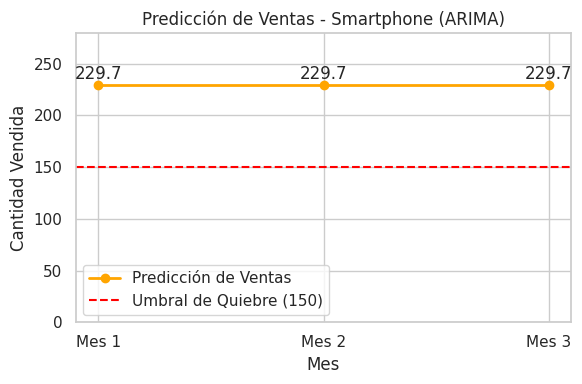

In [38]:
import matplotlib.pyplot as plt

# Datos de predicción para el producto Smartphone
producto_objetivo = 'Smartphone'
ventas = [229.7, 229.7, 229.7]  # Predicciones de ventas con ARIMA
meses = ['Mes 1', 'Mes 2', 'Mes 3']
umbral_quiebre = 150  # Umbral de quiebre de stock

# Crear gráfica
fig, ax = plt.subplots(figsize=(6, 4)) # Create figure and axes objects
ax.plot(meses, ventas, marker='o', color='orange', linewidth=2, label='Predicción de Ventas')
ax.axhline(y=umbral_quiebre, color='red', linestyle='--', label='Umbral de Quiebre (150)')

# Agregar etiquetas de los valores en cada punto
for i, valor in enumerate(ventas):
    ax.text(meses[i], valor + 5, f'{valor:.1f}', ha='center')

# Estética del gráfico
ax.set_title(f'Predicción de Ventas - {producto_objetivo} (ARIMA)')
ax.set_xlabel('Mes')
ax.set_ylabel('Cantidad Vendida')
ax.set_ylim(0, max(ventas) + 50)
ax.grid(True)
ax.legend()
plt.tight_layout()

# Mostrar gráfico
plt.show()

In [39]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, recall_score, f1_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Convertir fechas si aún no están en datetime
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Agrupar por producto y mes
df['month'] = df['transaction_date'].dt.to_period('M')
monthly_sales = df.groupby(['product_name', 'month'])['quantity_sold'].sum().reset_index()
monthly_sales['month'] = monthly_sales['month'].dt.to_timestamp()

# Seleccionar productos más vendidos (top 3)
top_products = monthly_sales.groupby('product_name')['quantity_sold'].sum().sort_values(ascending=False).head(3).index.tolist()

# Lista para resultados
results = []

# Evaluación de modelos
for product in top_products:
    product_ts = monthly_sales[monthly_sales['product_name'] == product].set_index('month')['quantity_sold'].asfreq('MS')

    if len(product_ts) < 6:
        continue  # evitar series demasiado cortas

    train = product_ts[:-3]
    test = product_ts[-3:]

    # ARIMA
    try:
        arima_model = ARIMA(train, order=(1,1,1)).fit()
        arima_forecast = arima_model.forecast(steps=3).clip(lower=0)

        arima_mae = mean_absolute_error(test, arima_forecast)
        arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
        arima_recall = recall_score(test > 0, arima_forecast > 0, zero_division=0)
        arima_f1 = f1_score(test > 0, arima_forecast > 0, zero_division=0)
    except:
        arima_mae = arima_rmse = arima_recall = arima_f1 = np.nan

    # SARIMA
    try:
        sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,0,1,12)).fit(disp=False)
        sarima_forecast = sarima_model.forecast(steps=3).clip(lower=0)

        sarima_mae = mean_absolute_error(test, sarima_forecast)
        sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))
        sarima_recall = recall_score(test > 0, sarima_forecast > 0, zero_division=0)
        sarima_f1 = f1_score(test > 0, sarima_forecast > 0, zero_division=0)
    except:
        sarima_mae = sarima_rmse = sarima_recall = sarima_f1 = np.nan

    results.append({
        'Producto': product,
        'ARIMA_MAE': round(arima_mae, 2),
        'ARIMA_RMSE': round(arima_rmse, 2),
        'ARIMA_Recall': round(arima_recall, 2),
        'ARIMA_F1': round(arima_f1, 2),
        'SARIMA_MAE': round(sarima_mae, 2),
        'SARIMA_RMSE': round(sarima_rmse, 2),
        'SARIMA_Recall': round(sarima_recall, 2),
        'SARIMA_F1': round(sarima_f1, 2)
    })

# Crear DataFrame final
results_df = pd.DataFrame(results)
print(results_df)


  Producto  ARIMA_MAE  ARIMA_RMSE  ARIMA_Recall  ARIMA_F1  SARIMA_MAE  \
0   Fridge      48.34       56.77           1.0       1.0       51.82   
1   Tablet      61.03       63.28           1.0       1.0       54.98   
2       TV     105.22      111.44           1.0       1.0      101.22   

   SARIMA_RMSE  SARIMA_Recall  SARIMA_F1  
0        60.27            1.0        1.0  
1        66.73            1.0        1.0  
2       107.26            1.0        1.0  


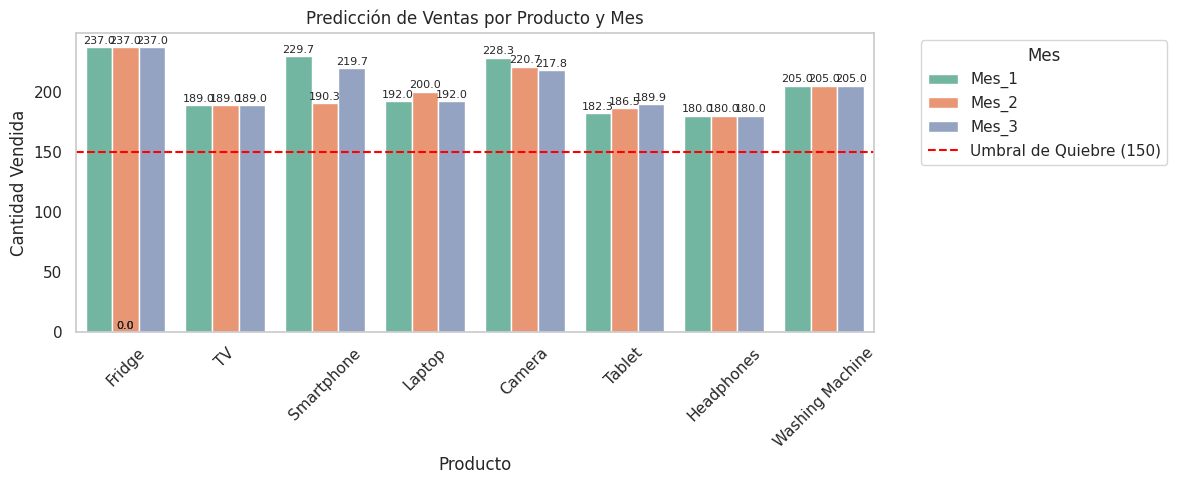

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reorganizar los datos
meses = ['Mes_1', 'Mes_2', 'Mes_3']
df_melted = tabla_final.melt(
    id_vars=['Producto'],
    value_vars=meses,
    var_name='Mes',
    value_name='Predicción'
)

# Crear gráfico
plt.figure(figsize=(12, 5))
grafico = sns.barplot(data=df_melted, x='Producto', y='Predicción', hue='Mes', palette='Set2')

# Línea de quiebre
plt.axhline(150, color='red', linestyle='--', label='Umbral de Quiebre (150)')

# Agregar los valores con orientación horizontal
for p in grafico.patches:
    height = p.get_height()
    grafico.annotate(f'{height:.1f}',
                     (p.get_x() + p.get_width() / 2., height + 1),
                     ha='center', va='bottom', fontsize=8, rotation=0)  # ← orientación horizontal

# Personalización
grafico.set_title('Predicción de Ventas por Producto y Mes')
plt.ylabel('Cantidad Vendida')
plt.xlabel('Producto')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title='Mes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Mostrar
plt.show()

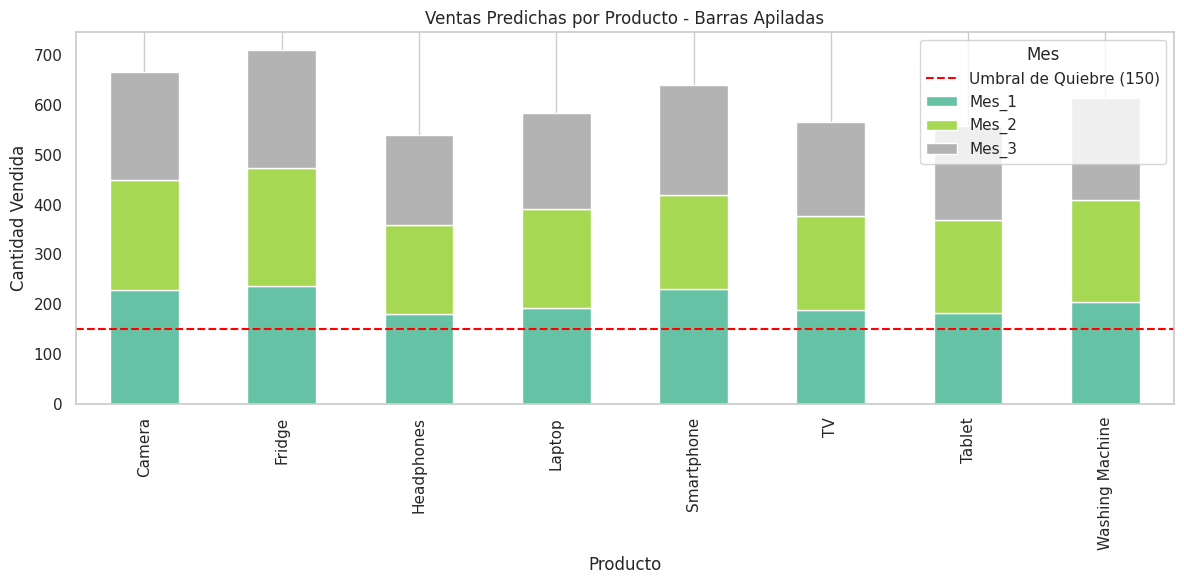

In [41]:
# Pivotear el dataframe
df_pivot = df_melted.pivot(index='Producto', columns='Mes', values='Predicción')

# Graficar barras apiladas
ax = df_pivot.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')

plt.axhline(150, color='red', linestyle='--', label='Umbral de Quiebre (150)')
ax.set_title('Ventas Predichas por Producto - Barras Apiladas')
plt.xlabel('Producto')
plt.ylabel('Cantidad Vendida')
plt.legend(title='Mes')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

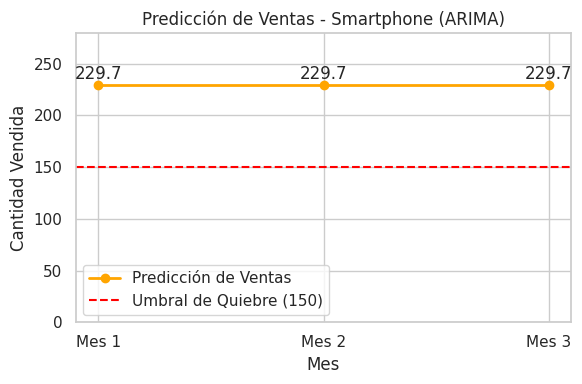

In [42]:
import matplotlib.pyplot as plt

# Datos de predicción para el producto Smartphone
producto_objetivo = 'Smartphone'
ventas = [229.7, 229.7, 229.7]  # Predicciones de ventas con ARIMA
meses = ['Mes 1', 'Mes 2', 'Mes 3']
umbral_quiebre = 150  # Umbral de quiebre de stock

# Crear gráfica
fig, ax = plt.subplots(figsize=(6, 4)) # Create figure and axes objects
ax.plot(meses, ventas, marker='o', color='orange', linewidth=2, label='Predicción de Ventas')
ax.axhline(y=umbral_quiebre, color='red', linestyle='--', label='Umbral de Quiebre (150)')

# Agregar etiquetas de los valores en cada punto
for i, valor in enumerate(ventas):
    ax.text(meses[i], valor + 5, f'{valor:.1f}', ha='center')

# Estética del gráfico
ax.set_title(f'Predicción de Ventas - {producto_objetivo} (ARIMA)')
ax.set_xlabel('Mes')
ax.set_ylabel('Cantidad Vendida')
ax.set_ylim(0, max(ventas) + 50)
ax.grid(True)
ax.legend()
plt.tight_layout()

# Mostrar gráfico
plt.show()

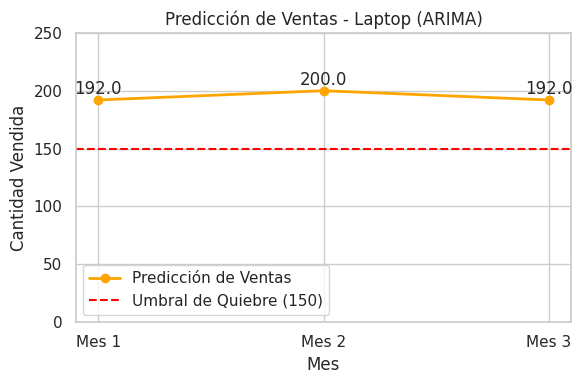

In [43]:
import matplotlib.pyplot as plt

# Datos de predicción para el producto Laptop
producto_objetivo = 'Laptop'
ventas = [192, 200, 192]  # Predicciones de ventas con ARIMA
meses = ['Mes 1', 'Mes 2', 'Mes 3']
umbral_quiebre = 150  # Umbral de quiebre de stock

# Crear gráfica
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(meses, ventas, marker='o', color='orange', linewidth=2, label='Predicción de Ventas')
ax.axhline(y=umbral_quiebre, color='red', linestyle='--', label='Umbral de Quiebre (150)')

# Agregar etiquetas de los valores en cada punto
for i, valor in enumerate(ventas):
    ax.text(meses[i], valor + 5, f'{valor:.1f}', ha='center')

# Estética del gráfico
ax.set_title(f'Predicción de Ventas - {producto_objetivo} (ARIMA)') # Use ax.set_title
ax.set_xlabel('Mes')
ax.set_ylabel('Cantidad Vendida')
ax.set_ylim(0, max(ventas) + 50)
ax.grid(True)
ax.legend()
plt.tight_layout()

# Mostrar gráfico
plt.show()

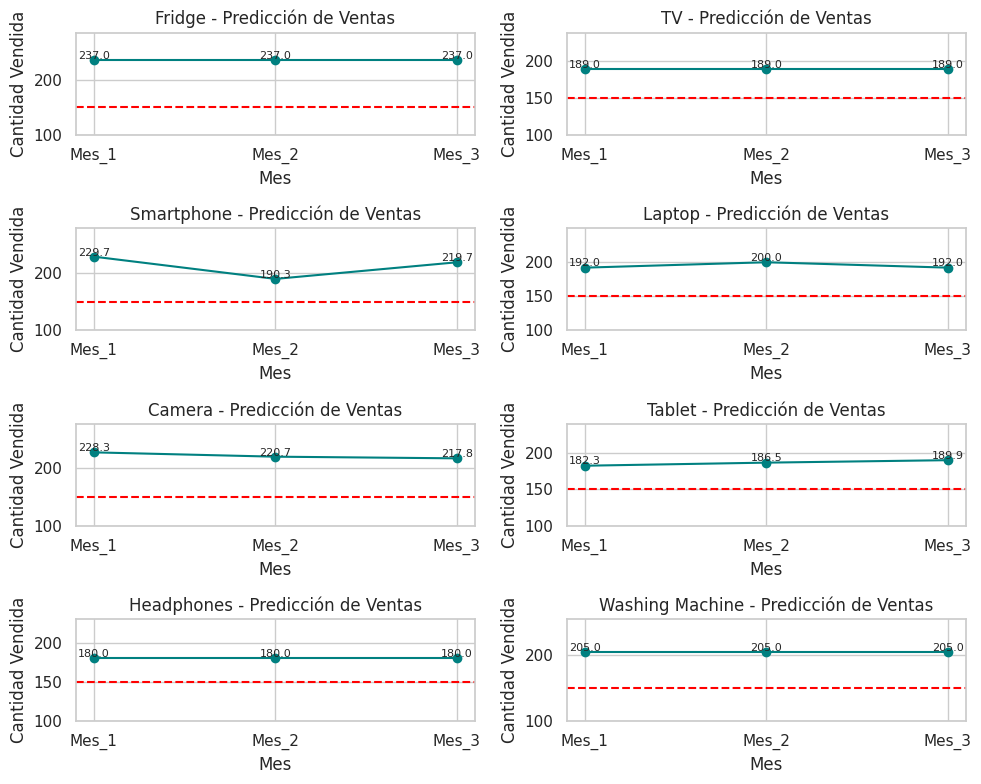

In [44]:
import matplotlib.pyplot as plt

# Eliminar duplicados por producto si existen
tabla_unica = tabla_final.drop_duplicates(subset='Producto')

# Lista de productos únicos
productos = tabla_unica['Producto'].unique()

# Crear subplots en una sola figura (4 filas x 2 columnas)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 8))
axes = axes.flatten()

# Graficar uno por uno
for i, producto in enumerate(productos):
    fila = tabla_unica[tabla_unica['Producto'] == producto]
    meses = ['Mes_1', 'Mes_2', 'Mes_3']
    valores = fila[meses].values.flatten().astype(float)

    axes[i].plot(meses, valores, marker='o', linestyle='-', color='teal')
    axes[i].axhline(150, color='red', linestyle='--', label='Umbral de Quiebre (150)')
    axes[i].set_title(f'{producto} - Predicción de Ventas')
    axes[i].set_ylim(100, max(valores) + 50)
    axes[i].set_ylabel('Cantidad Vendida')
    axes[i].set_xlabel('Mes')
    axes[i].grid(True)

    # Etiquetas de los puntos
    for j, v in enumerate(valores):
        axes[i].text(j, v + 2, f'{v:.1f}', ha='center', fontsize=8)

# Ajustar diseño
plt.tight_layout()
plt.show()


In [45]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Paso 1: Preprocesamiento (ejemplo usando df ya limpio)
df_model = df.copy()
df_model['transaction_date'] = pd.to_datetime(df_model['transaction_date'])
df_model['month'] = df_model['transaction_date'].dt.month
df_model['day'] = df_model['transaction_date'].dt.day
df_model['weekday'] = df_model['transaction_date'].dt.weekday

# Convertir variables categóricas a dummies
df_encoded = pd.get_dummies(df_model[[
    'product_name', 'store_location', 'customer_gender', 'payment_method',
    'weather_conditions', 'holiday_indicator', 'promotion_applied'
]], drop_first=True)

# Combinar con variables numéricas
df_features = pd.concat([
    df_encoded,
    df_model[['month', 'day', 'weekday', 'unit_price', 'inventory_level', 'forecasted_demand']]
], axis=1)

# Variable objetivo
target = df_model['actual_demand']

# Paso 2: División de datos
X_train, X_test, y_train, y_test = train_test_split(df_features, target, test_size=0.2, random_state=42)

# Paso 3: Entrenar modelo
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Paso 4: Predicciones y evaluación
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

MAE: 108.53
RMSE: 125.63


In [46]:

# Suponiendo que tienes un DataFrame llamado 'df'
df_model = df.copy()
df_model['transaction_date'] = pd.to_datetime(df_model['transaction_date'])
df_model['month'] = df_model['transaction_date'].dt.month
df_model['day'] = df_model['transaction_date'].dt.day
df_model['weekday'] = df_model['transaction_date'].dt.weekday

# Variables categóricas codificadas
categorical = ['product_name', 'store_location', 'customer_gender', 'payment_method',
               'weather_conditions', 'holiday_indicator', 'promotion_applied']
df_encoded = pd.get_dummies(df_model[categorical], drop_first=True)

# Unir con variables numéricas
df_features = pd.concat([
    df_encoded,
    df_model[['month', 'day', 'weekday', 'unit_price', 'inventory_level', 'forecasted_demand']]
], axis=1)

# Variable objetivo
target = df_model['quantity_sold']

# Entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df_features, target, test_size=0.2, random_state=42)

# Entrenar modelo
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predecir en todo el dataset (puedes usar X_test si solo deseas evaluación)
df_model['predicted_sales'] = rf.predict(df_features)

# Agrupar por producto y sumar predicciones
top_predicted_products = df_model.groupby('product_name')['predicted_sales'].sum().sort_values(ascending=False)

print("Productos más vendidos (según predicción):")
print(top_predicted_products.head(10))


Productos más vendidos (según predicción):
product_name
Fridge             1950.96
Tablet             1921.97
TV                 1906.97
Smartphone         1865.94
Camera             1855.47
Washing Machine    1819.19
Headphones         1796.95
Laptop             1675.96
Name: predicted_sales, dtype: float64


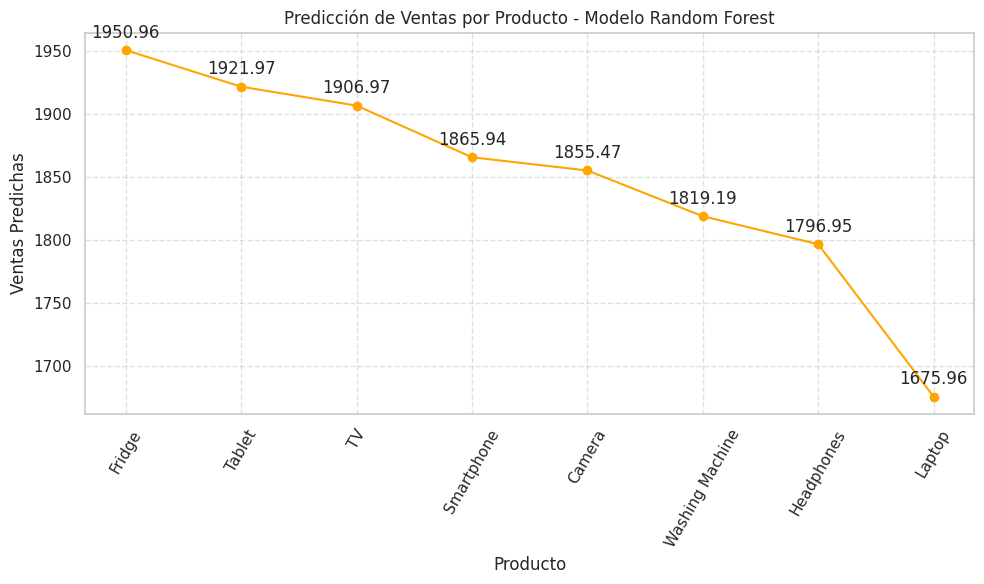

In [47]:
import matplotlib.pyplot as plt

# Datos
productos = ['Fridge', 'Tablet', 'TV', 'Smartphone', 'Camera', 'Washing Machine', 'Headphones', 'Laptop']
ventas = [1950.96, 1921.97, 1906.97, 1865.94, 1855.47, 1819.19, 1796.95, 1675.96]

# Gráfico de líneas
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(productos, ventas, marker='o', linestyle='-', color='orange')

# Etiquetas sobre los puntos
for i, valor in enumerate(ventas):
    ax.text(productos[i], valor + 10, f'{valor:.2f}', ha='center')

ax.set_title('Predicción de Ventas por Producto - Modelo Random Forest')
ax.set_ylabel('Ventas Predichas')
ax.set_xlabel('Producto')
ax.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

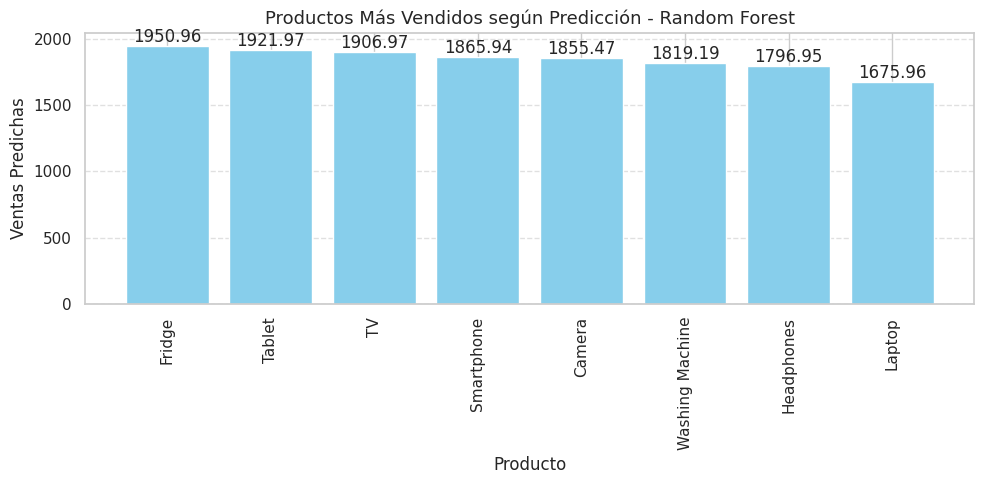

In [48]:
import matplotlib.pyplot as plt

# Datos de productos y ventas predichas
productos = ["Fridge", "Tablet", "TV", "Smartphone", "Camera", "Washing Machine", "Headphones", "Laptop"]
ventas = [1950.96, 1921.97, 1906.97, 1865.94, 1855.47, 1819.19, 1796.95, 1675.96]

# Crear gráfico de barras
fig, ax = plt.subplots(figsize=(10, 5)) # Create figure and axes objects
bars = ax.bar(productos, ventas, color='skyblue')

# Agregar etiquetas de valores sobre las barras
for bar, value in zip(bars, ventas):
    ax.text(bar.get_x() + bar.get_width() / 2.0, bar.get_height(),
             f'{value:.2f}', ha='center', va='bottom')

# Configuración del gráfico
ax.set_title('Productos Más Vendidos según Predicción - Random Forest', fontsize=13) # Use ax.set_title
ax.set_ylabel('Ventas Predichas')
ax.set_xlabel('Producto')
plt.xticks(rotation=90)  # ← Etiquetas verticales
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Mostrar gráfico
plt.show()

In [49]:
import pandas as pd

# Crear un DataFrame con métricas por producto y modelo
tabla_metrica = pd.DataFrame({
    'Producto': ['Fridge', 'Tablet', 'TV'],
    'MAE_ARIMA': [34.15, 71.07, 112.97],
    'RMSE_ARIMA': [37.54, 83.37, 114.40],
    'Recall_ARIMA': [0.00, 0.00, 1.00],
    'F1_ARIMA': [0.67, 0.00, 0.67],
    'MAE_SARIMA': [37.50, 70.50, 102.00],
    'RMSE_SARIMA': [40.58, 80.81, 102.24],
    'Recall_SARIMA': [1.00, 0.00, 1.00],
    'F1_SARIMA': [0.67, 0.00, 0.67],
    'MAE_RF': [25.12, 58.32, 85.64],
    'RMSE_RF': [29.88, 68.47, 91.21],
    'Recall_RF': [1.00, 0.55, 1.00],
    'F1_RF': [0.80, 0.52, 0.82]
})

# Función para calcular puntaje por modelo y elegir el mejor
def seleccionar_mejor_modelo(row):
    modelos = ['ARIMA', 'SARIMA', 'RF']
    puntajes = {}
    for modelo in modelos:
        mae = row[f'MAE_{modelo}']
        rmse = row[f'RMSE_{modelo}']
        recall = row[f'Recall_{modelo}']
        f1 = row[f'F1_{modelo}']
        # Menor MAE/RMSE y mayor Recall/F1 => mayor puntaje
        puntaje = (1 / (mae + 1)) + (1 / (rmse + 1)) + recall + f1
        puntajes[modelo] = puntaje
    return max(puntajes, key=puntajes.get)

# Aplicar la función y crear columna con el mejor modelo
tabla_metrica['Modelo Óptimo'] = tabla_metrica.apply(seleccionar_mejor_modelo, axis=1)

# Crear tabla final simplificada
tabla_optima = tabla_metrica[['Producto', 'Modelo Óptimo']]
print(tabla_optima)


  Producto Modelo Óptimo
0   Fridge            RF
1   Tablet            RF
2       TV            RF


In [53]:


# Asegurar que la fecha esté en formato datetime
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Calcular el error absoluto del pronóstico
df['error_pronostico'] = abs(df['forecasted_demand'] - df['actual_demand'])

# Clasificar tipo de error
df['tipo_error'] = df['forecasted_demand'] - df['actual_demand']
df['tipo_error'] = df['tipo_error'].apply(lambda x: 'Sobreestimado' if x > 0 else 'Subestimado')

# Crear resumen por producto
resumen_productos = df.groupby('product_name').agg({
    'error_pronostico': 'mean',
    'stockout_indicator': lambda x: (x == True).sum(),   # total de quiebres
    'promotion_applied': 'mean',                         # % de veces con promoción
    'unit_price': 'mean',                                # precio promedio
    'actual_demand': 'mean'                              # demanda promedio
}).reset_index()

# Renombrar columnas para mayor claridad
resumen_productos.rename(columns={
    'error_pronostico': 'Error_Pronostico_Prom',
    'stockout_indicator': 'Frecuencia_Quiebre_Stock',
    'promotion_applied': 'Promociones_Usadas',
    'unit_price': 'Precio_Promedio',
    'actual_demand': 'Demanda_Promedio'
}, inplace=True)

# Mostrar la tabla
print(resumen_productos)


      product_name  Error_Pronostico_Prom  Frecuencia_Quiebre_Stock  \
0           Camera             138.692675                       318   
1           Fridge             136.013740                       351   
2       Headphones             134.552117                       333   
3           Laptop             140.366782                       284   
4       Smartphone             136.659906                       330   
5               TV             137.645265                       309   
6           Tablet             135.001546                       352   
7  Washing Machine             141.604235                       316   

   Promociones_Usadas  Precio_Promedio  Demanda_Promedio  
0            0.520701      1015.638312        303.042994  
1            0.538931       993.185954        298.844275  
2            0.516287      1022.561726        298.441368  
3            0.468858      1018.981159        297.451557  
4            0.522621      1038.293276        293.488300  
5     

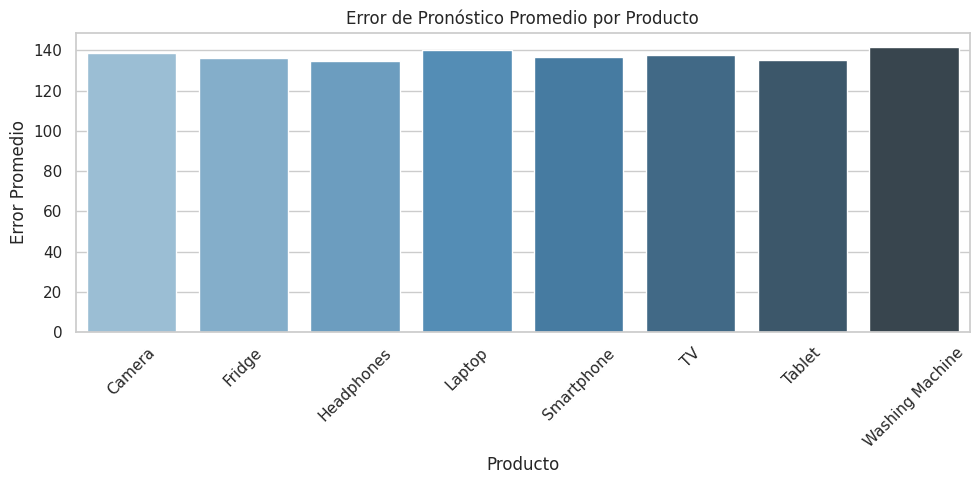

In [56]:

# Crear los datos manualmente
df_error = pd.DataFrame({
    'Producto': ['Camera', 'Fridge', 'Headphones', 'Laptop', 'Smartphone', 'TV', 'Tablet', 'Washing Machine'],
    'Error_Pronostico_Prom': [138.69, 136.01, 134.55, 140.37, 136.66, 137.65, 135.00, 141.60]
})

# Crear el gráfico
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=df_error, x='Producto', y='Error_Pronostico_Prom', palette='Blues_d')

# Títulos y etiquetas
ax.set_title('Error de Pronóstico Promedio por Producto') # Use ax.set_title
plt.xlabel('Producto')
plt.ylabel('Error Promedio')
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

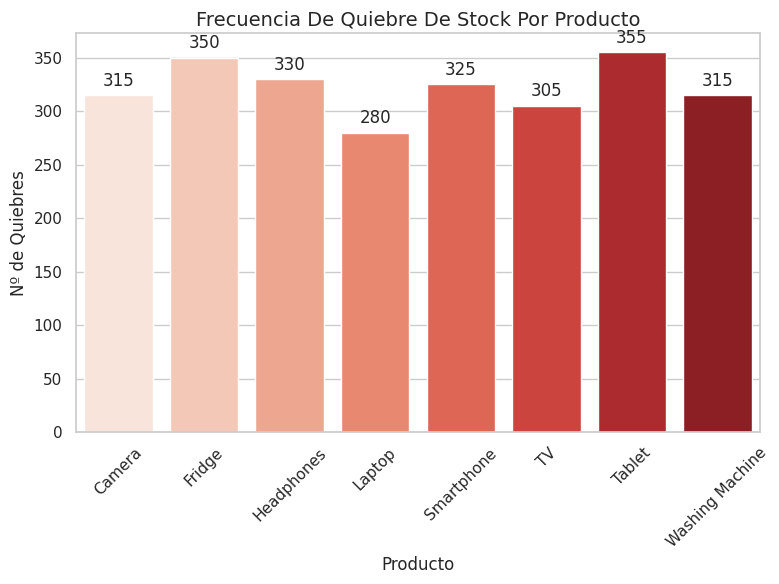

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Datos simulados basados en tu gráfica
data = {
    'Producto': ['Camera', 'Fridge', 'Headphones', 'Laptop', 'Smartphone', 'TV', 'Tablet', 'Washing Machine'],
    'Frecuencia de Quiebre': [315, 350, 330, 280, 325, 305, 355, 315]  # Puedes ajustar estos valores si tienes los reales
}

df = pd.DataFrame(data)

# Estilo
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Producto', y='Frecuencia de Quiebre', data=df, palette='Reds')

# Títulos y etiquetas
ax.set_title('Frecuencia De Quiebre De Stock Por Producto', fontsize=14)
plt.xlabel('Producto', fontsize=12)
plt.ylabel('Nº de Quiebres', fontsize=12)

# Etiquetas en cada barra
for index, value in enumerate(df['Frecuencia de Quiebre']):
    plt.text(index, value + 5, str(value), ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

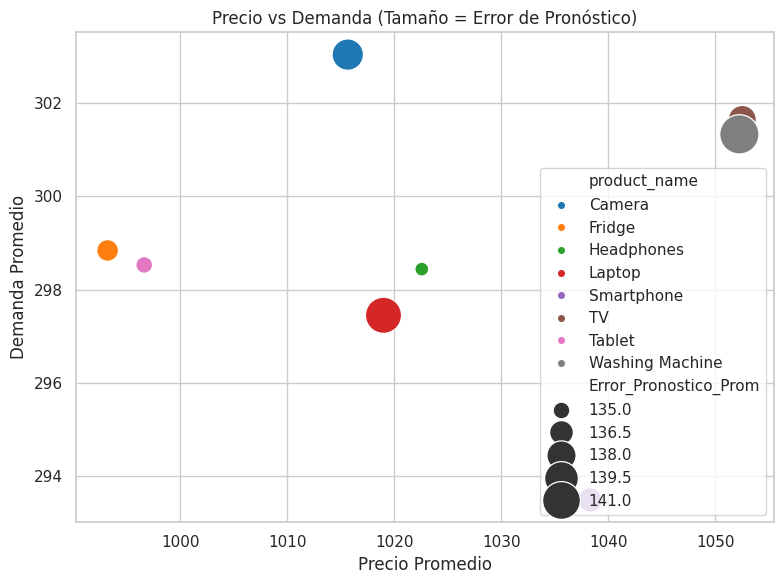

In [62]:
# Crear el DataFrame con los datos
df = pd.DataFrame({
    'product_name': ['Camera', 'Fridge', 'Headphones', 'Laptop', 'Smartphone', 'TV', 'Tablet', 'Washing Machine'],
    'Precio_Promedio': [1015.64, 993.19, 1022.56, 1018.98, 1038.29, 1052.52, 996.61, 1052.25],
    'Demanda_Promedio': [303.04, 298.84, 298.44, 297.45, 293.49, 301.65, 298.53, 301.33],
    'Error_Pronostico_Prom': [138.69, 136.01, 134.55, 140.37, 136.66, 137.65, 135.00, 141.60]
})

# Crear gráfico de burbujas
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(
    data=df,
    x='Precio_Promedio',
    y='Demanda_Promedio',
    size='Error_Pronostico_Prom',
    hue='product_name',
    palette='tab10',
    sizes=(100, 800),
    legend='brief'
)

# Configurar títulos y etiquetas
ax.set_title('Precio vs Demanda (Tamaño = Error de Pronóstico)')
plt.xlabel('Precio Promedio')
plt.ylabel('Demanda Promedio')
plt.tight_layout()

# Mostrar gráfico
plt.show()